# Amazon's marketplace fees

This notebook serves as a Proof of Concept (PoC) for the collection of Amazon's history of marketplace fees (`commissions` henceforth).

## Housekeeping

Useful imports.

In [1]:
import numpy as np
import pandas as pd

import requests
from bs4 import BeautifulSoup

import re

import time
import random

Target URL in the case of France.

In [2]:
target_url = "services.amazon.fr/services/vendre-sur-internet/tarifs.html"

Link currently redirects to [this page](https://sell.amazon.fr/vendre-sur-internet?ref_=asfr_soa_rd&).

Root of the URL used to get the content of the Wayback Machine:

In [3]:
wayback_machine_url_root = 'https://web.archive.org/web/'

## Code

### First call to the Wayback Machine

This first call to the Wayback Machine's API allows to identify all the points in time when the page was saved.

In [4]:
api_call = f"http://web.archive.org/cdx/search/cdx?url={target_url}&output=json"

In [5]:
response = requests.get(api_call)
resp_json = response.json()

In [6]:
print(type(resp_json))
print(len(resp_json))

<class 'list'>
218


The call returns a list of 218 elements. The first one provides information about the format of the response:

In [7]:
resp_json[0]

['urlkey',
 'timestamp',
 'original',
 'mimetype',
 'statuscode',
 'digest',
 'length']

And then, a typical element follows this structure:

In [8]:
resp_json[1]

['fr,amazon,services)/services/vendre-sur-internet/tarifs.html',
 '20130112023435',
 'http://services.amazon.fr:80/services/vendre-sur-internet/tarifs.html',
 'text/html',
 '200',
 'XMS2W6WAQPIPXLOAJDRJ63YS6LB3AWOL',
 '7354']

### Deducing a list of secondary API calls

We will then fetch the content of the page for each time stamp at which it was saved in the Wayback Machine.

In [9]:
url_dict = {'timestamp': [], 'url': []}

# The range skips the first element of the response, which only provides the structure of the response
for i in range(1, len(resp_json)):
    
    orig_url = resp_json[i][2]
    tstamp = resp_json[i][1]
    
    waylink = tstamp + '/' + orig_url
    
    url_dict['timestamp'].append(tstamp)
    url_dict['url'].append(waylink)

In [10]:
print('Number of pages saved in the Wayback Machine:', len(url_dict['url']))
print('Example of the first URL:', url_dict['url'][0])

Number of pages saved in the Wayback Machine: 217
Example of the first URL: 20130112023435/http://services.amazon.fr:80/services/vendre-sur-internet/tarifs.html


### Parsing the content of the first version saved

One may get an idea of the type of page whose content we are going to load:

In [11]:
final_url = wayback_machine_url_root + url_dict['url'][0]

In [12]:
print(final_url)

https://web.archive.org/web/20130112023435/http://services.amazon.fr:80/services/vendre-sur-internet/tarifs.html


We load the page and parse the HTML content.

In [13]:
response = requests.get(final_url)

In [14]:
soup = BeautifulSoup(response.text, "html.parser")

We retrieve the main table of commissions.

In [15]:
main_commission_table_str = str(soup.find_all(class_='categoryComissionTable')[0])

# The following lines remove the table notes that cannot be read with Pandas
idx_left = main_commission_table_str.rfind('<tr class="categoryComissionTableNote">')
idx_right = main_commission_table_str.rfind('</tr>') + len('</tr>')

main_commission_table_str = main_commission_table_str.replace(
    main_commission_table_str[idx_left:idx_right],
    ''
)

# We convert into a DataFrame
main_commission_df = pd.read_html(main_commission_table_str)[0]

# We clean the DataFrame
main_commission_df['Catégorie'] = main_commission_df['Catégorie'].map(
    lambda category: category.strip().replace("*", "").lower().replace('-', ' ')
)
main_commission_df['Commission variable'] = main_commission_df['Commission variable'].map(
    lambda commission: commission.replace(",", ".").replace("%", "").replace(" ", "")
)
main_commission_df = main_commission_df.rename(
    columns={'Catégorie': 'category', 'Commission variable': 'commission'}
)

# We add the time stamp
main_commission_df['timestamp'] = url_dict['timestamp'][0]

main_commission_df

,category,commission,timestamp
0,jeux vidéo et consoles,10.44,20130112023435
1,bijoux,20,20130112023435
2,dvd,10.44,20130112023435
3,fourniture de bureau,15,20130112023435
4,informatique,7,20130112023435
5,high tech,7,20130112023435
6,instruments de musique et sono,12,20130112023435
7,alimentation,15,20130112023435
8,livres,10.44,20130112023435
9,logiciels,10.44,20130112023435


In [101]:
for i in range(len(url_dict['url'][:10])):
    
    print(f"Starting the call #{i + 1}")
    
    final_url = wayback_machine_url_root + url_dict['url'][i]
    
    response = requests.get(final_url)
    soup = BeautifulSoup(response.text, "html.parser")
    
    main_commission_table_str = str(soup.find_all(class_='categoryComissionTable')[0])

    # The following lines remove the table notes that cannot be read with Pandas
    idx_left = main_commission_table_str.rfind('<tr class="categoryComissionTableNote">')
    idx_right = main_commission_table_str.rfind('</tr>') + len('</tr>')

    main_commission_table_str = main_commission_table_str.replace(
        main_commission_table_str[idx_left:idx_right],
        ''
    )

    # We convert into a DataFrame
    main_commission_df = pd.read_html(main_commission_table_str)[0]

    # We clean the DataFrame
    cols = main_commission_df.columns
    
    main_commission_df[cols[0]] = main_commission_df[cols[0]].map(
        lambda category: category.strip().replace("*", "").lower().replace('-', ' ')
    )
    main_commission_df[cols[1]] = main_commission_df[cols[1]].map(
        lambda commission: commission.replace(",", ".").replace("%", "").replace(" ", "")
    )
    
    main_commission_df = main_commission_df.rename(
        columns={cols[0]: 'category', cols[1]: 'commission'}
    )

    # We add the time stamp
    main_commission_df['timestamp'] = url_dict['timestamp'][i]
    
    if i == 0:
        full_df = main_commission_df.copy()
        
    else:
        full_df = pd.concat([full_df, main_commission_df])
        
    sleep_time = random.randint(10, 20)
    print(f"Sleeping for {sleep_time} seconds")
    time.sleep(sleep_time)
    
    print('------------------------------------')

Starting the call #1
Sleeping for 18 seconds
Starting the call #2
Sleeping for 11 seconds
Starting the call #3
Sleeping for 10 seconds
Starting the call #4
Sleeping for 18 seconds
Starting the call #5
Sleeping for 15 seconds
Starting the call #6
Sleeping for 20 seconds
Starting the call #7
Sleeping for 12 seconds
Starting the call #8
Sleeping for 16 seconds
Starting the call #9
Sleeping for 10 seconds
Starting the call #10
Sleeping for 18 seconds


In [104]:
full_df_first_10 = full_df.copy()

array(['jeux vidéo et consoles', 'bijoux', 'dvd', 'fourniture de bureau',
       'informatique', 'high tech', 'instruments de musique et sono',
       'alimentation', 'livres', 'logiciels', 'musique',
       'accessoires kindle', 'jeux et jouets',
       'toutes les autres catégories', 'jeux vidéo ',
       'consoles de jeux vidéo', 'gros électroménager',
       'accessoires high tech & informatique',
       'ordinateurs, périphériques pc et téléviseurs ',
       'médias (livres, musique, vidéos, dvds)'], dtype=object)

In [151]:
final_url = wayback_machine_url_root + url_dict['url'][150]
print(final_url)

https://web.archive.org/web/20170324092321/http://services.amazon.fr/services/vendre-sur-internet/tarifs.html


In [158]:
response = requests.get(final_url)
soup = BeautifulSoup(response.text, "html.parser")

ConnectionError: ('Connection aborted.', ConnectionResetError(54, 'Connection reset by peer'))

In [149]:
len(soup.find_all(class_='table-responsive'))

8

In [133]:
pd.read_html(str(soup.find_all(class_='table-responsive')[0]))[0]

,Catégories,Pourcentage des frais de vente,"Frais de vente minimum applicable(appliqué par article, sauf mention contraire)"
0,Accessoires High Tech ¹,12%**,"€ 0,50"
1,Accessoires pour ordinateurs ¹,12%**,"€ 0,50"
2,Accessoires pour appareils Amazon,45%,"€ 0,50"
3,Auto et moto,15%,"0,50 €"
4,Bijoux ¹,20%,"0,50 €"
5,Bricolage,12%,"0,50 €"
6,Consoles de Jeux-Vidéo,8%,-
7,Gros Électroménager,7%,"0,50 €"
8,High-Tech,7%,"0,50 €"
9,Instruments de musique et Sono,12%,"0,50 €"


In [23]:
for i in range(128, 128 + len(url_dict['url'][128:])):
    
    print(f"Starting the call #{i + 1}")
    
    final_url = wayback_machine_url_root + url_dict['url'][i]
    
    response = requests.get(final_url)
    soup = BeautifulSoup(response.text, "html.parser")
    
    if len(soup.find_all(class_='categoryComissionTable')) > 0:
        main_commission_table_str = str(soup.find_all(class_='categoryComissionTable')[0])
        
    elif len(soup.find_all(class_='table commision-info')) > 0:
        main_commission_table_str = str(soup.find_all(class_='table commision-info')[0])
        
    elif len(soup.find_all(class_='table-responsive')) > 0:
        main_commission_table_str = str(soup.find_all(class_='table-responsive')[0])
        
    else:
        continue

    # The following lines remove the table notes that cannot be read with Pandas
    # idx_left = main_commission_table_str.rfind('<tr')
    # idx_right = main_commission_table_str.rfind('</tr>') + len('</tr>')

    # main_commission_table_str = main_commission_table_str.replace(
    #     main_commission_table_str[idx_left:idx_right],
    #     ''
    # )

    # We convert into a DataFrame
    main_commission_df = pd.read_html(main_commission_table_str)[0]

    # We clean the DataFrame
    cols = main_commission_df.columns
    
    main_commission_df[cols[0]] = main_commission_df[cols[0]].map(
        (
            lambda category: category.strip().replace("*", "").lower().replace('-', ' ')
            if isinstance(category, str) else category
        )
    )
    main_commission_df[cols[1]] = main_commission_df[cols[1]].map(
        lambda commission: commission.replace(",", ".").replace("%", "").replace('*', '').replace(" ", "")
        if isinstance(commission, str) else commission
    )
    
    main_commission_df = main_commission_df.rename(
        columns={cols[0]: 'category', cols[1]: 'commission'}
    )
    
    if len(cols) == 3:
        main_commission_df[cols[2]] = main_commission_df[cols[2]].map(
            lambda min_fee: min_fee.replace(",", ".").replace("€", "").replace('*', '').replace(" ", "")
            if isinstance(min_fee, str) else min_fee
        )
        main_commission_df = main_commission_df.rename(columns={cols[2]: 'min_sales_fee'})

    # We add the time stamp
    main_commission_df['timestamp'] = url_dict['timestamp'][i]
    
    if i == 0:
        full_df = main_commission_df.copy()
        
    else:
        full_df = pd.concat([full_df, main_commission_df])
        
    sleep_time = random.randint(10, 20)
    print(f"Sleeping for {sleep_time} seconds")
    time.sleep(sleep_time)
    
    print('------------------------------------')

Starting the call #129
Sleeping for 17 seconds
------------------------------------
Starting the call #130
Sleeping for 12 seconds
------------------------------------
Starting the call #131
Sleeping for 17 seconds
------------------------------------
Starting the call #132
Sleeping for 11 seconds
------------------------------------
Starting the call #133
Sleeping for 20 seconds
------------------------------------
Starting the call #134
Sleeping for 14 seconds
------------------------------------
Starting the call #135
Sleeping for 16 seconds
------------------------------------
Starting the call #136
Sleeping for 12 seconds
------------------------------------
Starting the call #137
Sleeping for 13 seconds
------------------------------------
Starting the call #138
Sleeping for 14 seconds
------------------------------------
Starting the call #139
Sleeping for 18 seconds
------------------------------------
Starting the call #140
Sleeping for 17 seconds
-----------------------------

ConnectionError: HTTPSConnectionPool(host='web.archive.org', port=443): Max retries exceeded with url: /web/20190723082136/https://services.amazon.fr/services/vendre-sur-internet/tarifs.html (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x115913450>: Failed to establish a new connection: [Errno 61] Connection refused'))

In [33]:
full_df['category'] = full_df['category'].map(
    (
        lambda category: category.replace('1', '').replace('2', '').replace('¹', '').strip()
        if isinstance(category, str) else category
    )
)

In [37]:
full_df = full_df[
    ~full_df['category'].map(
        (
            lambda category: category.startswith('une autorisation est')
            if isinstance(category, str) else False
        )
    )
].copy()

In [40]:
full_df = full_df[
    ~full_df['category'].map(
        (
            lambda category: category.startswith('pour vendre')
            if isinstance(category, str) else False
        )
    )
].copy()

In [44]:
full_df = full_df[~full_df['category'].isnull()].copy()

In [46]:
sorted(full_df['category'].unique())

['accessoires high tech',
 'accessoires high tech & informatique',
 'accessoires kindle',
 'accessoires pour appareils amazon',
 'accessoires pour ordinateurs',
 'alimentation',
 'auto et moto',
 'bijoux',
 'bricolage',
 'catégories',
 'commerce, industrie et science',
 'consoles de jeux vidéo',
 'dvd',
 'fourniture de bureau',
 'fournitures électriques industrielles',
 'gros électroménager',
 'high tech',
 'impression et numerisation 3d',
 'informatique',
 'instruments de musique et sono',
 'jeux et jouets',
 'jeux vidéo',
 'jeux vidéo et consoles',
 'livres',
 'livres, musique, vidéos, dvd',
 'livres, vidéos, dvd',
 'logiciels',
 'logiciels, jeux vidéos',
 'manutention de matériel',
 'montres',
 'musique',
 'médias (livres, musique, vidéos, dvds)',
 'ordinateurs, périphériques pc et téléviseurs',
 'outils manuels et électriques',
 'pneus',
 'services alimentaires',
 'toutes les autres catégories',
 'travail métallurgique']

In [49]:
full_df['timestamp_dt'] = pd.to_datetime(full_df['timestamp'])

In [54]:
full_df = full_df[
    ~full_df['commission'].isin(
        ['12avecunfraisdeventeminimumparunitéde0.50€', "Pourcentagedesfraisdevente"]
    )
].copy()

full_df['commission'] = full_df['commission'].astype(float)

In [77]:
ser = full_df.groupby('category').count()['timestamp'].sort_values(ascending=False)
ser[ser > 100].index

Index(['instruments de musique et sono', 'toutes les autres catégories',
       'bijoux', 'high tech', 'gros électroménager',
       'ordinateurs, périphériques pc et téléviseurs',
       'consoles de jeux vidéo', 'pneus', 'bricolage'],
      dtype='object', name='category')

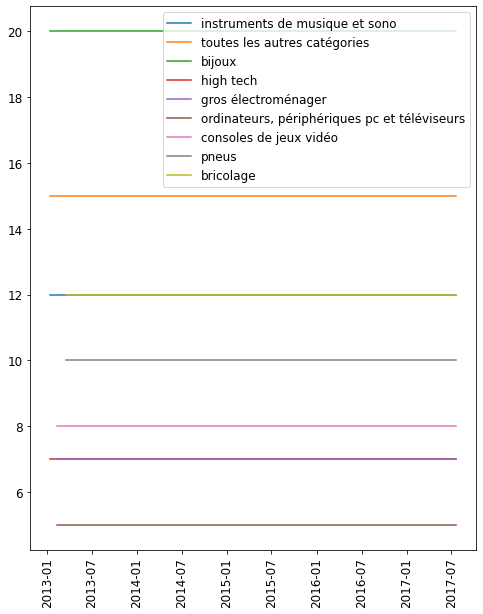

In [92]:
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 12})

plt.figure(figsize=(8, 10))

for category in ser[ser > 100].index:
    
    temp_df = full_df[full_df['category'] == category].copy()
    
    plt.plot(temp_df['timestamp_dt'], temp_df['commission'], label=category)
    
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [38]:
full_df_copy = full_df.copy()

In [28]:
full_df[~full_df['min_sales_fee'].isnull()].head(5)

,category,commission,timestamp,min_sales_fee
0,catégories,Pourcentagedesfraisdevente,20141026232431,Fraisdeventeminimumapplicable(appliquéparartic...
1,accessoires high tech1,12,20141026232431,0.50
2,accessoires pour ordinateurs1,12,20141026232431,0.50
3,accessoires pour appareils amazon,45,20141026232431,0.50
4,auto et moto,15,20141026232431,0.50


In [24]:
full_df

,category,commission,timestamp,min_sales_fee
0,jeux vidéo et consoles,10.44,20130112023435,NaN
1,bijoux,20,20130112023435,NaN
2,dvd,10.44,20130112023435,NaN
3,fourniture de bureau,15,20130112023435,NaN
4,informatique,7,20130112023435,NaN
...,...,...,...,...
19,pneus,10,20170718082218,0.50
20,services alimentaires,15,20170718082218,0.50
21,travail métallurgique,12,20170718082218,0.50
22,toutes les autres catégories,15,20170718082218,0.50


In [17]:
main_commission_df

,Catégories,Pourcentage des frais de vente,"Frais de vente minimum applicable(appliqué par article, sauf mention contraire)"
0,Accessoires High Tech ¹,12%**,"€ 0,50"
1,Accessoires pour ordinateurs ¹,12%**,"€ 0,50"
2,Accessoires pour appareils Amazon,45%,"€ 0,50"
3,Auto et moto,15%,"0,50 €"
4,Bijoux ¹,20%,"0,50 €"
5,Bricolage,12%,"0,50 €"
6,Consoles de Jeux-Vidéo,8%,-
7,Gros Électroménager,7%,"0,50 €"
8,High-Tech,7%,"0,50 €"
9,Instruments de musique et Sono,12%,"0,50 €"


In [19]:
full_df.tail()

,category,commission,timestamp,min_sales_fee
13,montres1,15,20151121051631,1.50
14,"ordinateurs, périphériques pc et téléviseurs",5,20151121051631,0.50
15,pneus,10,20151121051631,0.50
16,toutes les autres catégories,15,20151121051631,0.50
17,1pour vendre les produits de certaines catégor...,1Pourvendrelesproduitsdecertainescatégoriessur...,20151121051631,1Pourvendrelesproduitsdecertainescatégoriessur...


In [157]:
soup

<html><body><h1>429 Too Many Requests</h1>
You have sent too many requests in a given amount of time.
</body></html>

In [153]:
temp_df = full_df.copy()

In [156]:
full_df['category'].unique()

array(['jeux vidéo et consoles', 'bijoux', 'dvd', 'fourniture de bureau',
       'informatique', 'high tech', 'instruments de musique et sono',
       'alimentation', 'livres', 'logiciels', 'musique',
       'accessoires kindle', 'jeux et jouets',
       'toutes les autres catégories',
       'une autorisation est nécessaire pour vendre dans certaines catégories sur amazon. contactez nous pour demander une autorisation. merci de noter que seuls les vendeurs qui rempliront les critères de performance seront autorisés à vendre au sein de notre boutique jeux et jouets pendant la période de noël. (en savoir plus).',
       'une autorisation est nécessaire pour vendre dans certaines catégories sur amazon. contactez nous pour demander une autorisation.',
       'jeux vidéo ', 'consoles de jeux vidéo', 'gros électroménager',
       'accessoires high tech & informatique',
       'ordinateurs, périphériques pc et téléviseurs ',
       'médias (livres, musique, vidéos, dvds)', 'bricolage', 'pneu

In [154]:
full_df = full_df[full_df['category'] != 'catégories'].copy()
full_df['min_sales_fee'] = full_df['min_sales_fee'].map(lambda x: {'-', 0}.get(x, x))
full_df['min_sales_fee'] = full_df['min_sales_fee'].astype(float)
full_df['commission'] = full_df['commission'].astype(float)

KeyError: 'min_sales_fee'

In [124]:
full_df.tail(50)

,category,commission,timestamp,2
1,accessoires high tech1,12**,20151112140728,"€ 0,50"
2,accessoires pour ordinateurs1,12**,20151112140728,"€ 0,50"
3,accessoires pour appareils amazon,45,20151112140728,"€ 0,50"
4,auto et moto,15,20151112140728,"€ 0,50"
5,bijoux1,20,20151112140728,"€ 1,50"
6,bricolage,12,20151112140728,"€ 0,50"
7,consoles de jeux vidéo,8,20151112140728,-
8,gros électroménager,7,20151112140728,"€ 0,50"
9,high tech,7,20151112140728,"€ 0,50"
10,instruments de musique et sono,12,20151112140728,"€ 0,50"


In [113]:
main_commission_table_str

'<table class="categoryComissionTable">\n<tbody>\n<tr>\n<th>Catégorie </th>\n<th>Commission variable </th>\n</tr>\n<tr>\n<td> Jeux-Vidéo et consoles </td>\n<td> 10,44% </td>\n</tr>\n<tr class="highlight">\n<td> Bijoux* </td>\n<td> 20% </td>\n</tr>\n<tr>\n<td><span class="caps">DVD</span></td>\n<td> 10,44% </td>\n</tr>\n<tr>\n<td> Fourniture de bureau </td>\n<td> 15% </td>\n</tr>\n<tr>\n<td> Informatique </td>\n<td> 7% </td>\n</tr>\n<tr>\n<td> High-Tech </td>\n<td> 7% </td>\n</tr>\n<tr>\n<td> Instruments de Musique et Sono </td>\n<td> 12% </td>\n</tr>\n<td> Bricolage </td>\n<td>12% </td>\n<tr class="highlight">\n<td> Alimentation* </td>\n<td> 15% </td>\n</tr>\n<tr>\n<td> Livres </td>\n<td> 10,44% </td>\n</tr>\n<tr>\n<td> Logiciels </td>\n<td> 10,44% </td>\n</tr>\n<tr>\n<td> Musique </td>\n<td> 10,44% </td>\n</tr>\n<tr>\n<td> Accessoires Kindle </td>\n<td> 35% </td>\n</tr>\n<tr>\n<td> Jeux et Jouets** </td>\n<td> 15% </td>\n</tr>\n<tr>\n<td> Toutes les autres catégories </td>\n<td> 15% <

In [115]:
len(main_commission_table_str)

966

In [120]:
print(final_url)

https://web.archive.org/web/20130712094156/http://services.amazon.fr:80/services/vendre-sur-internet/tarifs.html


In [114]:
idx_left

948

In [108]:
full_df['timestamp'].unique()

array(['20130112023435', '20130113181121', '20130114132059',
       '20130116143328', '20130121090628', '20130126125058',
       '20130205002006', '20130208080529', '20130215103309',
       '20130225005045'], dtype=object)

In [105]:
full_df['timestamp'].nunique()

10

In [93]:
full_df[full_df['category'] == 'high tech']['commission'].unique()

array(['7'], dtype=object)

In [62]:
main_commission_df

,Catégorie,Commission variable
0,Jeux-Vidéo et consoles,10.44
1,Bijoux,20
2,DVD,10.44
3,Fourniture de bureau,15
4,Informatique,7
5,High-Tech,7
6,Instruments de Musique et Sono,12
7,Alimentation,15
8,Livres,10.44
9,Logiciels,10.44


In [26]:
commissions = {'category': [], 'commission': []}

for i, td in enumerate(soup.find_all('td')):
    if "%" in td.text:
        commission = float(td.text.replace(",", ".").replace("%", "").replace(" ", ""))
        category = soup.find_all('td')[i - 1].text.strip().replace("*", "")
        
        commissions['category'].append(category)
        commissions['commission'].append(commission)
        
commissions_df = pd.DataFrame.from_dict(commissions)
commissions_df

,category,commission
0,Jeux-Vidéo et consoles,10.44
1,Bijoux,20.00
2,DVD,10.44
3,Fourniture de bureau,15.00
4,Informatique,7.00
5,High-Tech,7.00
6,Instruments de Musique et Sono,12.00
7,Bricolage,12.00
8,Alimentation,15.00
9,Livres,10.44


In [55]:

euro_occurences = [m.start() for m in re.finditer('€', response.text)]

In [56]:
response.text[response.text.find('€')-5:response.text.find('€')+5]

'>0,99€</sp'

In [57]:
response.text[15203-5:15203+5]

'39,00€ for'

In [58]:
for idx in euro_occurences:
    print(response.text[idx - 5:idx + 5])

>0,99€</sp
39,00€ for
 0,77€ à 2
 2,63€ </t
 0,30€ à 2
 2,63€ </t
 0,51€ à 2
 2,63€ </t
ur 23€ sur
 2,99€</di
r 150€ sur
 5,99€</di


In [30]:
re.findall(r'\d+\,?\d{0,2}[$€£]', response.text, re.UNICODE)

['0,99€',
 '39,00€',
 '0,77€',
 '2,63€',
 '0,30€',
 '2,63€',
 '0,51€',
 '2,63€',
 '23€',
 '2,99€',
 '150€',
 '5,99€']

In [39]:
main_commission_table_str = str(soup.find_all(class_='categoryComissionTable')[0])

In [40]:
main_commission_table_str.find('categoryComissionTableNote')

959

In [44]:
main_commission_table_str[959 - 11:959 + 10]

'<tr class="categoryCo'

In [56]:
idx_left = main_commission_table_str.rfind('<tr class="categoryComissionTableNote">')
idx_right = main_commission_table_str.rfind('</tr>') + len('</tr>')

main_commission_table_str.replace(
    main_commission_table_str[idx_left:idx_right],
    ''
)

'<table class="categoryComissionTable">\n<tbody>\n<tr>\n<th>Catégorie </th>\n<th>Commission variable </th>\n</tr>\n<tr>\n<td> Jeux-Vidéo et consoles </td>\n<td> 10,44% </td>\n</tr>\n<tr class="highlight">\n<td> Bijoux* </td>\n<td> 20% </td>\n</tr>\n<tr>\n<td><span class="caps">DVD</span></td>\n<td> 10,44% </td>\n</tr>\n<tr>\n<td> Fourniture de bureau </td>\n<td> 15% </td>\n</tr>\n<tr>\n<td> Informatique </td>\n<td> 7% </td>\n</tr>\n<tr>\n<td> High-Tech </td>\n<td> 7% </td>\n</tr>\n<tr>\n<td> Instruments de Musique et Sono </td>\n<td> 12% </td>\n</tr>\n<td> Bricolage </td>\n<td>12% </td>\n<tr class="highlight">\n<td> Alimentation* </td>\n<td> 15% </td>\n</tr>\n<tr>\n<td> Livres </td>\n<td> 10,44% </td>\n</tr>\n<tr>\n<td> Logiciels </td>\n<td> 10,44% </td>\n</tr>\n<tr>\n<td> Musique </td>\n<td> 10,44% </td>\n</tr>\n<tr>\n<td> Accessoires Kindle </td>\n<td> 35% </td>\n</tr>\n<tr>\n<td> Jeux et Jouets** </td>\n<td> 15% </td>\n</tr>\n<tr>\n<td> Toutes les autres catégories </td>\n<td> 15% <

In [58]:
pd.read_html(
    main_commission_table_str.replace(
        main_commission_table_str[idx_left:idx_right],
        ''
    )
)[0]

,Catégorie,Commission variable
0,Jeux-Vidéo et consoles,"10,44%"
1,Bijoux*,20%
2,DVD,"10,44%"
3,Fourniture de bureau,15%
4,Informatique,7%
5,High-Tech,7%
6,Instruments de Musique et Sono,12%
7,Alimentation*,15%
8,Livres,"10,44%"
9,Logiciels,"10,44%"


## Cross-country comparisons

In [6]:
countries = {
    'France': {
        'ISO': 'FRA',
        'short': 'fr',
        'keyword': 'tarifs'
    },
    'United Kingdom': {
        'ISO': 'GBR',
        'short': 'co.uk',
        'keyword': 'pricing'
    },
    'Italy': {
        'ISO': 'ITA',
        'short': 'it',
        'keyword': 'prezzi'
    },
    'Spain': {
        'ISO': 'ESP',
        'short': 'es',
        'keyword': 'precios'
    },
    'Germany': {
        'ISO': 'DEU',
        'short': 'de',
        'keyword': 'preisgestaltung'
    },
    'Poland': {
        'ISO': 'POL',
        'short': 'pl',
        'keyword': 'oplaty'
    },
    'Australia': {
        'ISO': 'AUS',
        'short': 'au',
        'keyword': ''
    },
    'Belgium': {
        'ISO': 'BEL',
        'short': 'be',
        'keyword': ''
    },
    'Brazil': {
        'ISO': 'BRA',
        'short': 'br',
        'keyword': ''
    },
    'Canada': {
        'ISO': 'CAN',
        'short': 'ca',
        'keyword': ''
    },
    'China': {
        'ISO': 'CHN',
        'short': 'cn',
        'keyword': ''
    },
    'India': {
        'ISO': 'IND',
        'short': 'in',
        'keyword': ''
    },
    'Japan': {
        'ISO': 'JPN',
        'short': 'jp',
        'keyword': ''
    },
    'Korea': {
        'ISO': 'KOR',
        'short': 'kr',
        'keyword': ''
    },
    'Mexico': {
        'ISO': 'MEX',
        'short': 'mx',
        'keyword': ''
    },
    'Netherlands': {
        'ISO': 'NLD',
        'short': 'nl',
        'keyword': ''
    },
    'Saudi Arabia': {
        'ISO': 'SAU',
        'short': 'sa',
        'keyword': ''
    },
    'Singapore': {
        'ISO': 'SGP',
        'short': 'sg',
        'keyword': ''
    },
    'Sweden': {
        'ISO': 'SWE',
        'short': 'se',
        'keyword': ''
    },
    'Taiwan': {
        'ISO': 'TWN',
        'short': 'tw',
        'keyword': ''
    },
    'Thailand': {
        'ISO': 'THA',
        'short': 'th',
        'keyword': ''
    },
    'Turkey': {
        'ISO': 'TUR',
        'short': 'tr',
        'keyword': ''
    },
    'Turkey': {
        'ISO': 'TUR',
        'short': 'tr',
        'keyword': ''
    },
    'United Arab Emirates': {
        'ISO': 'UAE',
        'short': 'ae',
        'keyword': ''
    },
    'United Arab Emirates': {
        'ISO': 'UAE',
        'short': 'ae',
        'keyword': ''
    },
    'United States': {
        'ISO': 'USA',
        'short': '',
        'keyword': ''
    },
    'Vietnam': {
        'ISO': 'VNM',
        'short': 'vn',
        'keyword': ''
    },
}

In [8]:
len(countries.keys())

25

In [7]:
for country, values in countries.items():
    
    print(country)
    
    url_base = "https://sell.amazon."
    
    url = url_base + values['short']
    
    print(url)
    
    response = requests.get(url)
    print(response)

France
https://sell.amazon.fr
<Response [200]>
United Kingdom
https://sell.amazon.co.uk
<Response [200]>
Italy
https://sell.amazon.it
<Response [200]>
Spain
https://sell.amazon.es
<Response [200]>
Germany
https://sell.amazon.de
<Response [200]>
Poland
https://sell.amazon.pl
<Response [200]>
Australia
https://sell.amazon.au


KeyboardInterrupt: 